# Reactive covering

## Introduction

EXPLAIN

In [3]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import math
from docplex.mp.model import Model

import random
import json

def showSolution(data,solution):
    
    # print the booking strategy
    print("Bookings:")
    for booking in solution['Bookings']:
        print(booking)

    # show the passes
    minVisiDuration = data['minVisiDuration']
    AOIs = data['AOIs']
    nAOIs = len(AOIs)
    accesses = data['Accesses']
    satPasses = data['Passes']
    nPasses = len(satPasses)
    
    ncols = 3
    nrows = math.ceil(nPasses / ncols)
    proj = ccrs.PlateCarree()
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols, subplot_kw={'projection': proj},figsize=(30,80))
    axs = axs.flatten()

    for i in range(nPasses):
        satPass = satPasses[i]
        ax = axs[i]
        ax.set_extent([-15, 25, 35, 60])
        ax.stock_img()
        ax.add_feature(cf.COASTLINE, lw=1)
        ax.add_feature(cf.BORDERS)
        #plt.gcf().set_size_inches(15, 15)    
        for aoi in  AOIs:
            ax.plot([aoi['lon']], [aoi['lat']], 'kx')
        ax.set_title("Pass #{} [{},{}]".format(i,satPass['startDate'],satPass['endDate']))
    
        booking = None
        for bk in solution['Bookings']:
            if bk['passId'] == i:
                booking = bk            
                break
        
        for accessId in satPass['accessIds']:
            access = accesses[accessId]
            aoi = AOIs[access['aoiId']]            
            ax.plot([aoi['lon']], [aoi['lat']], 'rx')
            # show the reservations
            if (booking != None) and (booking['bookingStart'] <= access['end'] - minVisiDuration) and (access['start'] + minVisiDuration <= booking['bookingEnd']):
                ax.plot([aoi['lon']], [aoi['lat']], 'bo')

    plt.show()

## Stage 1

Explicar como hemos calculado el coste y como hemos definido la quality y meter un poco de paja rollo intro

In [13]:
# Import the data
dataFile = open('data/data12.json')  
data = json.load(dataFile)
accesses = data['Accesses']
obsRequests = data['ObservationRequests']
nObsRequests = len(obsRequests)
covered = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
satPasses = data['Passes']
nPasses = len(satPasses)

# Very basic solver
remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
for i in remainingSatPassesIds:
    # Try to select the ith path
    satPass = satPasses[i]
    keepPass = False
    for accessId in satPass['accessIds']:
        access = accesses[accessId]
        for j in range(nObsRequests):
            obsRequest = obsRequests[j]
            if not covered[j] and accessId in obsRequest['accessIds']:
                covered[j] = True
                keepPass = True
                nObsRequestsToCover -= 1
                
    if keepPass:
        selectedPassIds.append(i)
            
    if nObsRequestsToCover == 0:
        break

# Computation of the total cost
timeCost = sum([satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds])
totalCost = len(selectedPassIds)*data['fixedPassCost'] + timeCost*data['passCostPerTimeUnit']

# Computation of the quality of the covering
quality = 0

print("IDs of the {0} selected passes: {1}".format(len(selectedPassIds), selectedPassIds))
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))

# Export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

IDs of the 7 selected passes: [14, 54, 62, 28, 31, 67, 34]
Total cost of the covering: 2333
Quality of the covering: 0


Bookings:
{'passId': 14, 'passStart': 9254, 'passEnd': 9464, 'bookingStart': 9254, 'bookingEnd': 9464}
{'passId': 54, 'passStart': 34712, 'passEnd': 34774, 'bookingStart': 34712, 'bookingEnd': 34774}
{'passId': 62, 'passStart': 39446, 'passEnd': 39512, 'bookingStart': 39446, 'bookingEnd': 39512}
{'passId': 28, 'passStart': 19341, 'passEnd': 19648, 'bookingStart': 19341, 'bookingEnd': 19648}
{'passId': 31, 'passStart': 20690, 'passEnd': 20920, 'bookingStart': 20690, 'bookingEnd': 20920}
{'passId': 67, 'passStart': 42288, 'passEnd': 42569, 'bookingStart': 42288, 'bookingEnd': 42569}
{'passId': 34, 'passStart': 23170, 'passEnd': 23507, 'bookingStart': 23170, 'bookingEnd': 23507}


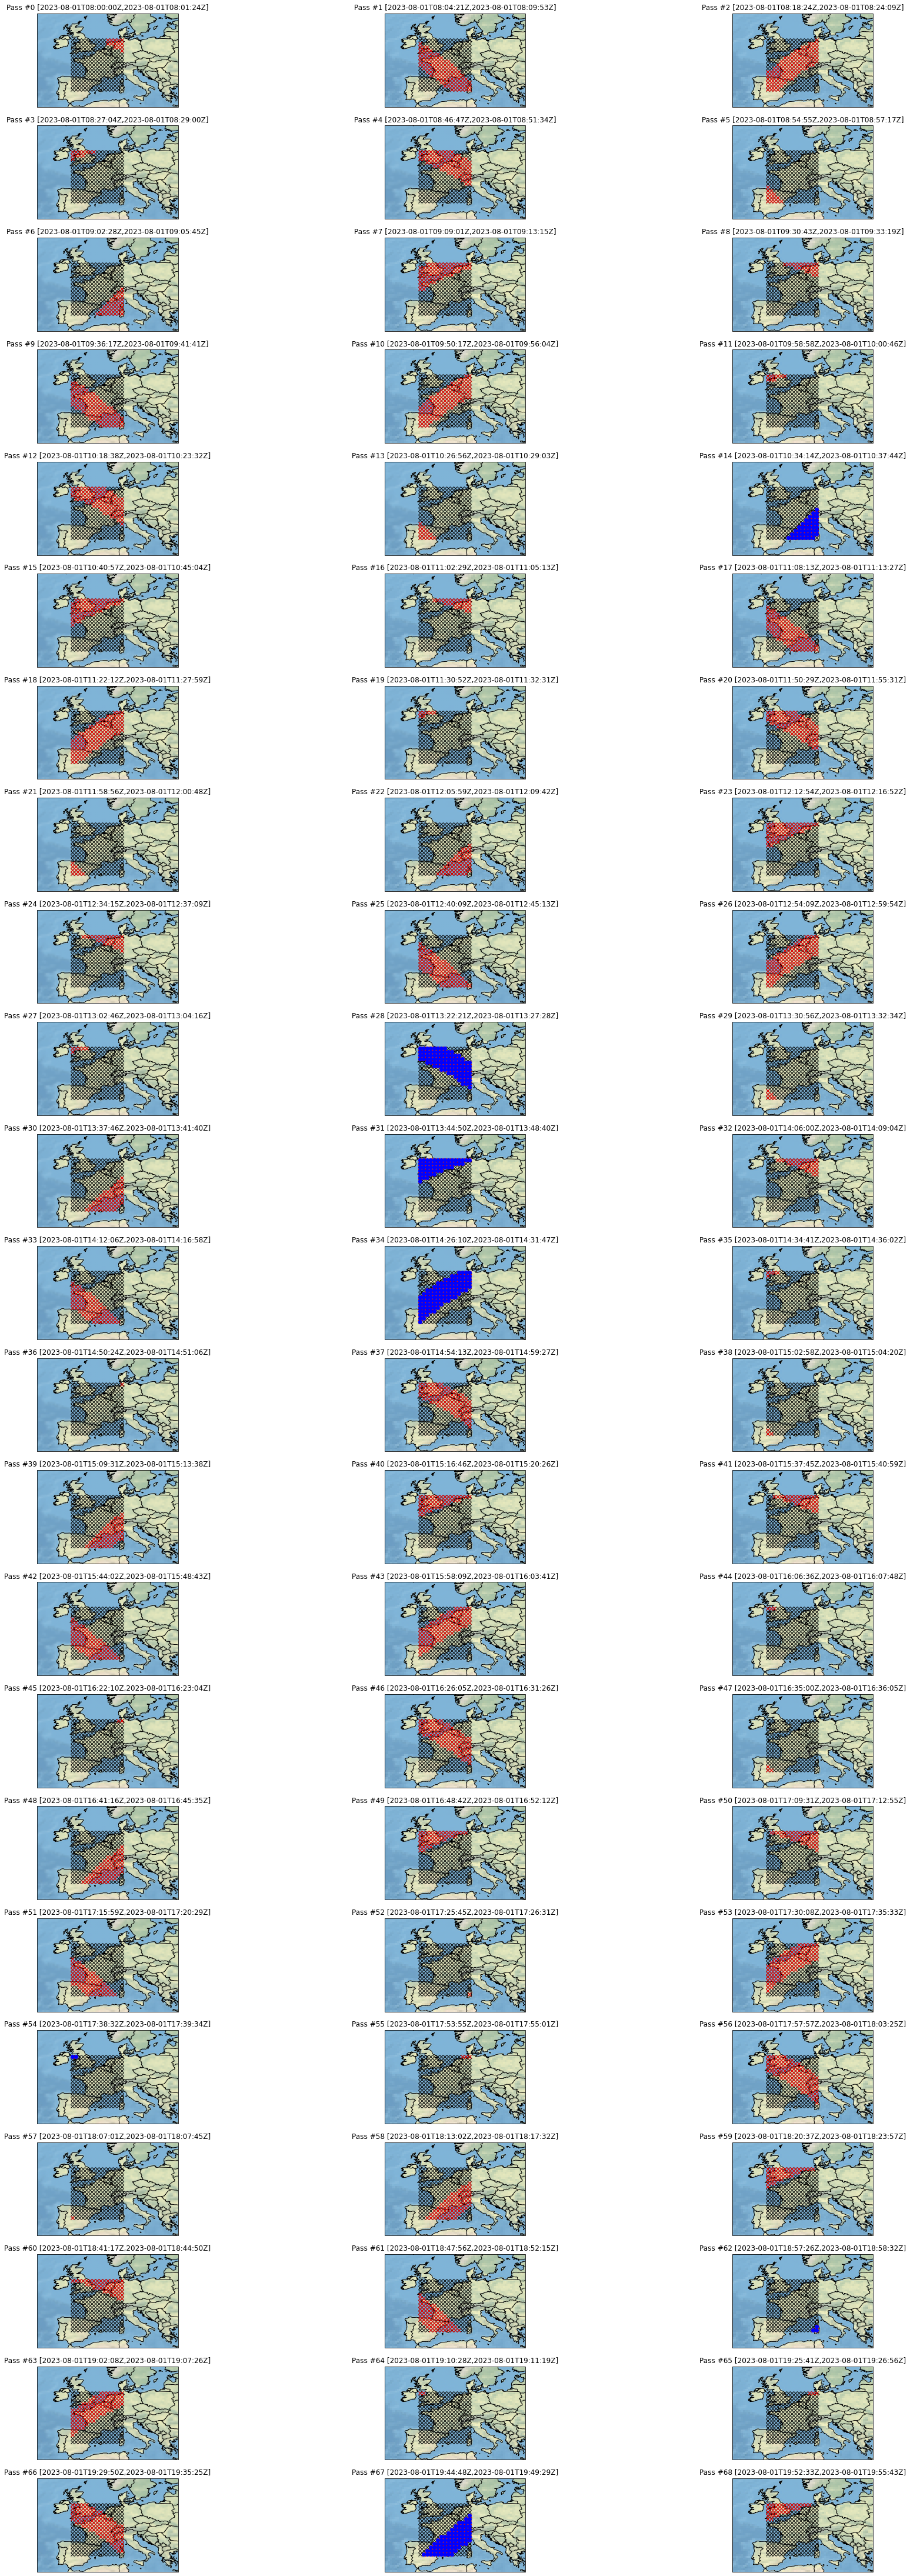

In [14]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)

showSolution(data,solution)

## Stage 2

EXPLAIN

In [24]:

# Import the data
dataFile = open('data/data12.json')  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nObsRequests = len(obsRequests)
nObsRequestsToCover = nObsRequests
nPasses = len(satPasses)

# Parameters
maxBudget = 2700 # Modify if required

# We start considering all the AOIs uncovered
covered = [False for i in range(nObsRequests)]



# OPTIMISATION MODEL
# Model creation
model = Model("reactiveCovering")

# Variables
selectedPassIds = model.binary_var_list(range(nPasses),name='selectedPassIds')
#??? timeSelectedPass = model.continious_var_matrix(range(nObsRequests),name='timeSelectedPass')

# Objectif
#??? model.minimize(len(selectedPassIds)*data['fixedPassCost'] + sum([satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds])*data['passCostPerTimeUnit'])
# Maximise the priority

# Contraints:
# 1) Minimum time
# model.add_constraint(     >= 30)

# 2) Cost below maximum budget
# model.add_constraint(     <= maxBudget)


# Solve
# solution = model.solve(log_output=True)


# a very basic solver
remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
for i in remainingSatPassesIds:
    # try to select the ith path
    satPass = satPasses[i]
    keepPass = False
    for accessId in satPass['accessIds']:
        access = accesses[accessId]
        for j in range(nObsRequests):
            obsRequest = obsRequests[j]
            if not covered[j] and accessId in obsRequest['accessIds']:
                covered[j] = True
                keepPass = True
                nObsRequestsToCover -= 1
                
    if keepPass:
        selectedPassIds.append(i)
            
    if nObsRequestsToCover == 0:
        break

# OLD: Start
# Computation of the total cost
timeCost = sum([satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds])
totalCost = len(selectedPassIds)*data['fixedPassCost'] + timeCost*data['passCostPerTimeUnit']

# Computation of the quality of the covering
quality = 0

print("IDs of the {0} selected passes: {1}".format(len(selectedPassIds), selectedPassIds))
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))
#OLD: End

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()


[docplex.mp.Var(type=B,name='selectedPassIds_0'), docplex.mp.Var(type=B,name='selectedPassIds_1'), docplex.mp.Var(type=B,name='selectedPassIds_2'), docplex.mp.Var(type=B,name='selectedPassIds_3'), docplex.mp.Var(type=B,name='selectedPassIds_4'), docplex.mp.Var(type=B,name='selectedPassIds_5'), docplex.mp.Var(type=B,name='selectedPassIds_6'), docplex.mp.Var(type=B,name='selectedPassIds_7'), docplex.mp.Var(type=B,name='selectedPassIds_8'), docplex.mp.Var(type=B,name='selectedPassIds_9'), docplex.mp.Var(type=B,name='selectedPassIds_10'), docplex.mp.Var(type=B,name='selectedPassIds_11'), docplex.mp.Var(type=B,name='selectedPassIds_12'), docplex.mp.Var(type=B,name='selectedPassIds_13'), docplex.mp.Var(type=B,name='selectedPassIds_14'), docplex.mp.Var(type=B,name='selectedPassIds_15'), docplex.mp.Var(type=B,name='selectedPassIds_16'), docplex.mp.Var(type=B,name='selectedPassIds_17'), docplex.mp.Var(type=B,name='selectedPassIds_18'), docplex.mp.Var(type=B,name='selectedPassIds_19'), docplex.m

In [ ]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)

showSolution(data,solution)

## Stage 3

EXPLAIN